# NLP - final project (Part I)

### Group 4
- Maya Shani
- Naama Kollmann

In this notebook we will create a classification model which takes a set of movie reviews as input and outputs a label. Each review will get a positive or negative label, based on it's content, using LSTM recurrent neural network. The input data will be pre processed and than converted into word embedding. In our project we used Word2Vec and Glove embedding methods, but the ETL presented below can be used for any embedding method of your choice.

### First step - installing and importing the relevant packages:

In [ ]:
!pip install torch
!pip install cython
!pip install gensim --user
!pip install contractions
!pip install wordcloud

In [4]:
import gensim
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os 
from typing import Optional
from nltk.tokenize import word_tokenize 
import nltk
nltk.download("stopwords")
from string import punctuation, ascii_lowercase
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import contractions
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import math
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Second step - uploading and preprocessing the Data:
In this part we will load the data and perform pre processing on each review in order to train the model on relevant and suitable words. The clean_text function preforms pre processing will contains the following steps:
1. Removing HTML tags
2. Expand contractions - For example - convert 'don't' to 'do not'
3. Converting the word to lower case
4. Removing numbers
5. Ignoring stop words and non allowed symbols
6. Taking words that are longer than 1 character

In [5]:
stop_words = set(stopwords.words('english'))  # import a set of common stop words we would like to ignore in our model
allowed_symbols = set(l for l in ascii_lowercase)  # using ASCII to allow only English letters in lower case 

In [6]:
# in this function we wil preprocess the data in order to use it in our NLP model
def clean_text(text_file):
    clean_review = []  # empty list to hold the output
    soup = BeautifulSoup(text_file[0], "html.parser")  # set an object to remove html tags 
    text_file = soup.get_text(separator=" ")
    text_file = contractions.fix(text_file)  # expand contractions - convert 'don't' to 'do not'
    for word in word_tokenize(text_file):
        new_word = word.lower()  # lowercase
        new_word = gensim.parsing.preprocessing.strip_numeric(new_word)  # take out numbers
        if new_word not in stop_words:  # take words that are not in the stopwords list 
            new_word = "".join([character for character in new_word if character in allowed_symbols])  # add chars that are in the allowed symbols
            if len(new_word) > 1:  # take words that are longer than one character
                clean_review.append(new_word)
    return clean_review

In [7]:
# in this function we wil load the data from your local folder and perform the clean_data function 
def open_data(path):
    all_reviews = []  # set a list to hold all the reviews of that type (positive/negative)
    count = 0  # set a counter
    for (roots, dirs, files) in os.walk(path):  # open the reviews from the local folder 
        for file_dir in files:  # go over the reviews in the folder
            count += 1
            file = open(roots+ f'/{file_dir}', 'r', encoding='utf-8')
            text = file.readlines()  # turn review into a readable object
            clean = clean_text(text)  # preprocess text with cleaning function
            if count == 1:  # example of the preprocessing for one review per data set
                print(text)
                print(clean)
            all_reviews.append(clean)  # add review to the reviews list
    return all_reviews

In [8]:
negative = open_data('C:/Users/USER/train_data/train/neg')
positive = open_data('C:/Users/USER/train_data/train/pos')

["Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."]
['story', 'man', 'unnatural', 'feelings', 'pig', 'starts', 'opening', 'scene', 'terrific', 'example', 'absurd', 'comedy', 'formal', 'orchestra', 'audience', 'turned', 'insane', 'violent', 'mob', 'crazy', 'chantings', 'singers', 'unfortunately', 'stays', 'absurd', 'whole', 'time', 'general', 'narrative', 'eventually', 'making', 'putting', 

In [9]:
# create combined data set of negative and positive reviews
reviews = negative + positive
# create labels lists for the data
neg_labels = [0 for i in range(len(negative))]
pos_labels = [1 for i in range(len(positive))]
labels = neg_labels + pos_labels

In [10]:
# split the data to train and validation sets
test_precentage = 0.1
train_set, valid_set, labels_train, labels_valid = train_test_split(reviews, labels, test_size = test_precentage, shuffle = True, random_state = 42)

### Visualizations - Let the data speak:
Let's make some intresting explorations using visualizations

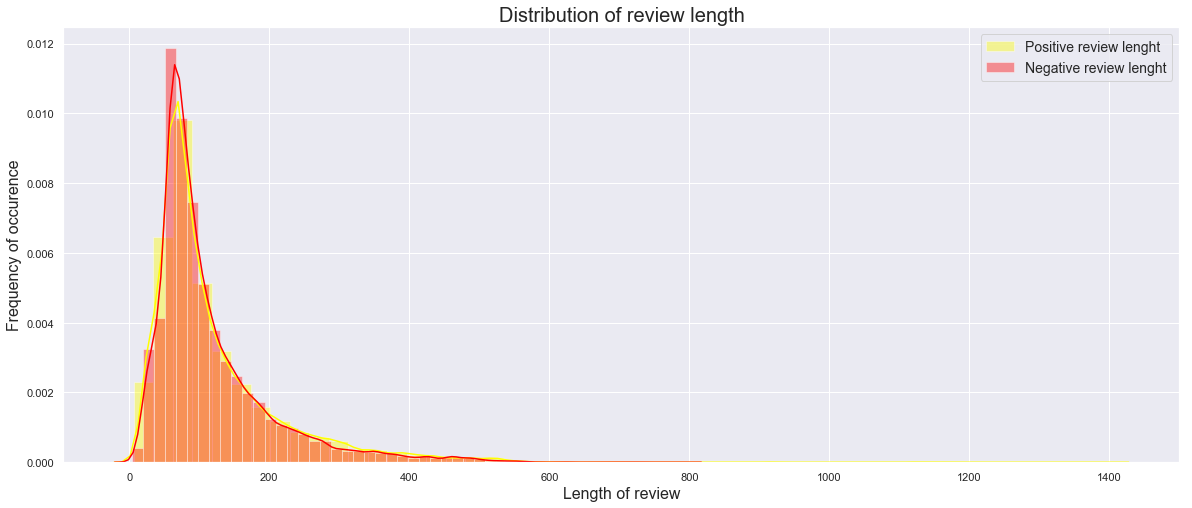

In [144]:
# this function creates the distribution of review length
def review_length_visual(positive_set, negative_set):
    pos_rev_len, neg_rev_len = [], []
    for r in range(len(positive_set)):
        pos_rev_len.append(len(positive_set[r]))
        neg_rev_len.append(len(negative_set[r]))
    fig, ax = plt.subplots(figsize=(20, 8))
    sns.set(font_scale=1)
    sns.distplot(pos_rev_len, color='yellow', label = 'Positive review lenght')
    sns.distplot(neg_rev_len, color='red', label = 'Negative review lenght')
    plt.legend(fontsize=14)
    plt.xlabel('Length of review', fontsize=16)
    plt.ylabel('Frequency of occurence', fontsize=16)
    plt.title('Distribution of review length', fontsize=20)
    plt.show()

review_length_visual(positive, negative)

In this graph we can see the distribution in the length of the reviews, split to positive and negative reviews. From examining the graph we can identify that both positive and negative reviews have a very similiar length distribution, which is helpful for the modeling stage since we know that the reviews will behave pretty much the same way. We can also see that most of the reviews are around ~60-80 words. Moreover, we can see that there are more positive reviews that are longer since we can identify a longer right yellow (positive) tail.

comparing labels for train:


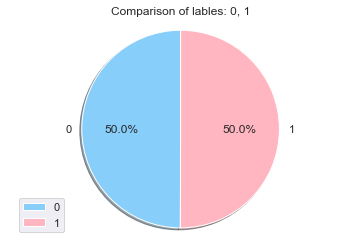

comparing labels for validation:


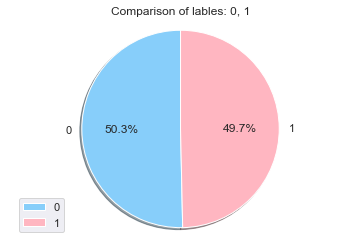

In [69]:
# counts the number of '0' labels and '1' labels, creating a pie chart 
def pie_chart(labels):
    count_0, count_1 = 0, 0
    for l in labels:
        if l == 0:
            count_0 += 1
        else:
            count_1 += 1                     
    names = '0', '1'  # labels as strings
    sizes = [count_0, count_1]
    colors = ["lightskyblue", "lightpink"]                                     
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels = names, colors = colors, autopct = '%1.1f%%',  
            shadow = True, startangle = 90)  # create the pie chart
    ax1.axis('equal')  # create a circular pie
    plt.title('Comparison of lables: 0, 1')  # create title
    plt.legend(names, loc = 3)  # add legend
    plt.show()
    
print('comparing labels for train:')
pie_chart(labels_train)
print('comparing labels for validation:')
pie_chart(labels_valid)

This Pie Chart used us to confirm that there is an equal distribution of negative and positive reviews in the train set and the validation set.

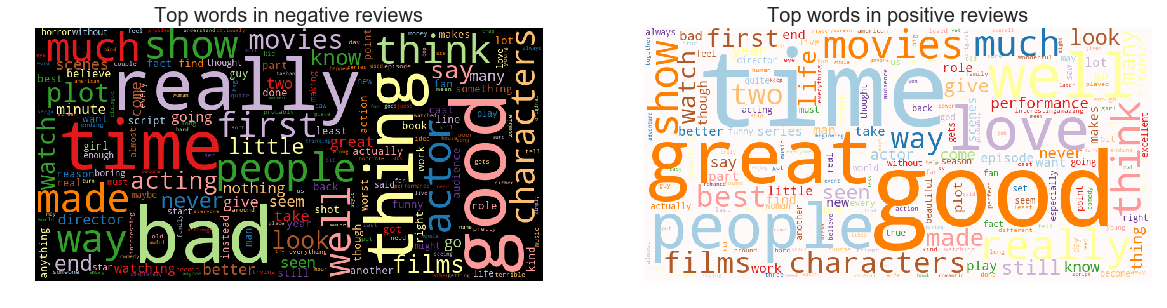

In [151]:
# in the lines below we will create two graphs that present the most common words in each data set (positive/negative)
n_posts = 500  # set a number of reviews from each data set to examin
output_neg, output_pos = '', ''
ignore = ['movie', 'character', 'film', 'one', 'story', 'even', 'make', 'scene', 'see']  # put asaide some common words
for rev in negative[:n_posts]:  # create output string for the graph
    for word in rev:
        if word not in ignore:
            output_neg += word + ' '
for rev in positive[:n_posts]:  # create output string for the graph
    for word in rev:
        if word not in ignore:
            output_pos += word + ' '
wordcloud_n = WordCloud(max_font_size=None, scale = 2, colormap = 'Paired').generate(output_neg)
wordcloud_p = WordCloud(max_font_size=None, scale = 2, colormap = 'Paired', background_color = 'snow').generate(output_pos)
fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_n)
ax[0].set_title('Top words in negative reviews',fontsize = 20)
ax[0].axis("off")
ax[1].imshow(wordcloud_p)
ax[1].set_title('Top words in positive reviews',fontsize = 20)
ax[1].axis("off")
plt.show()

From looking at the words graphs above we can see that as expected, in the positive reviews we can identify common words that are related to the positive words semantic field - good, great, well, love, best. In general, we can see that the result is clearer in the positive reviews graph than the negative one, but we can still identify some negative words like bad, never, nothing etc.

### Third step - creating the embedding methods:
In this part we will create data sets based on different embedding methods, Word2Vec and Glove. We assume that evantually the results on the RNN will be pretty similiar between the two methods based on previous articles and reviews on these methods, as discussed in class.

#### First embedding method - Word2Vec:

In [70]:
WORD_2_VEC_PATH = 'word2vec.model'

In [71]:
# define the model's variables
vec_size = 300
window_size = 5
min_words_count = 5
num_of_epoch = 30

model = gensim.models.Word2Vec.load(WORD_2_VEC_PATH)  # load word 2 vec model
model = gensim.models.Word2Vec(vector_size = vec_size, window = window_size, min_count = min_words_count, epochs = num_of_epoch)
model.build_vocab(train_set)
model.train(train_set, total_examples = model.corpus_count, epochs = model.epochs)

(110448870, 118688880)

In [79]:
# let's check if it works (:
w1 = "actor"
model.wv.most_similar(positive=w1)

[('actress', 0.6185986995697021),
 ('actors', 0.5487406849861145),
 ('comedian', 0.4498339593410492),
 ('role', 0.44591283798217773),
 ('performance', 0.3993311822414398),
 ('impersonation', 0.3807184398174286),
 ('actoractress', 0.37512728571891785),
 ('performer', 0.369843453168869),
 ('cast', 0.3488045036792755),
 ('comedienne', 0.34327200055122375)]

#### Second embedding method - Glove:

In [3]:
import gensim.downloader as api
glove_path = api.load('glove-wiki-gigaword-300', return_path=True)  # If we want to save the model to a local file
try:
    glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path)
except:
    glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path, binary=True)

In [80]:
glove_model.most_similar(positive=w1)

[('actress', 0.7266826033592224),
 ('starring', 0.6812140345573425),
 ('actors', 0.6726308465003967),
 ('comedian', 0.6627832651138306),
 ('starred', 0.6417394876480103),
 ('screenwriter', 0.6182526350021362),
 ('movie', 0.599695086479187),
 ('film', 0.5939877033233643),
 ('musician', 0.5826490521430969),
 ('comedy', 0.5588476061820984)]

From a short look on the similarity of the given word, it seems that the similarity scores are higher for the glove model, which means that the model is more certain of the given outputs. We'll keep that in mind going forward.

#### Converting words into vectors:
This function converts the words in each review in the data set into embeddings for the given model type (Word2Vec or Glove). This implementation can be used for any other embedding method with the relevant embedding extratction method of the model.

In [162]:
# this function converts the datasets into embedding vectors
def review2vec(dataset, model_type):
    data_vec = []
    counter = 0
    total = 0
    for review in dataset:
        rev_vec = [] 
        for word in review:
            total += 1
            if model_type == 'word2vec':
                if word not in model.wv.key_to_index:
                    counter += 1
                    continue
                gensim_vector = torch.Tensor(model.wv.get_vector(word))  # take the embedding vector
            else:
                if word not in glove_model.key_to_index:
                    counter += 1
                    continue
                gensim_vector = glove_model[word]  # take the embedding vector 
            rev_vec.append(gensim_vector)
        data_vec.append(rev_vec)
    precentage = round((counter / total), 3)
    print('for model ' + model_type + ' there are ' + str(counter) + ' words out of vocabulary')
    print('which are ' + str(precentage) + ' out of ' + str(total) + ' total words')
    return data_vec

In [163]:
# creating embedding for train and validation sets in both embedding methods
w2v_train_vec = review2vec(train_set, 'word2vec')
w2v_valid_vec = review2vec(valid_set, 'word2vec')
glv_train_vec = review2vec(train_set, 'glove')
glv_valid_vec = review2vec(valid_set, 'glove')

for model word2vec there are 114538 words out of vocabulary
which are 0.029 out of 3956296 total words
for model word2vec there are 15014 words out of vocabulary
which are 0.035 out of 429151 total words
for model glove there are 74277 words out of vocabulary
which are 0.019 out of 3956296 total words
for model glove there are 8002 words out of vocabulary
which are 0.019 out of 429151 total words


#### Self-Check: 
In the lines above we can see that there are words that are not in the models vocabulary and are being ignored in our implementation. The precentage of these words out of the data set is less than 3.5% for each combination of data set (train or validation) and model (word2vec, glove). This precentage is negligible when using data set that is as that big, and for that reason we can drop these words and continue.

### Fourth step - implementing LSTM NN:
The equations below were taken from the article "Gate-Variants of Gated Recurrent Unit (GRU) Neural
Networks" By Rahul Dey and Fathi M. Salem and will be used in our implementation of the LSTM network in the class below.

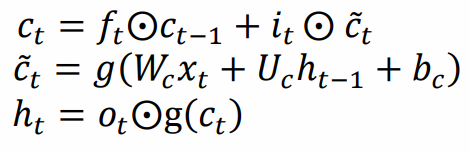
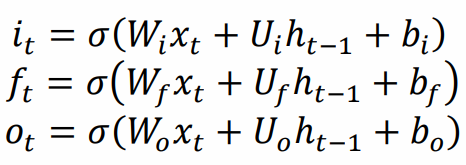

In [168]:
class LSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int, embedding_type: str):  # creating the objects of the model
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        self.embedding_type = embedding_type
        
        #i_t
        self.W_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        #f_t
        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        #c_t
        self.W_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        #o_t
        self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.create_label = nn.Parameter(torch.Tensor(hidden_sz, 1))
        self.init_weights()
    
    def init_weights(self):  # intialize weights for all the layers
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    
    def forward(self, x): 
        h_t, c_t = torch.zeros(self.hidden_size), torch.zeros(self.hidden_size)  # intialize hidden states
        for t in range(len(x)):  # go over the words in the review
            x_t = x[t]  # embedding of word t
            if self.embedding_type == 'Glove':
                x_t = torch.from_numpy(x_t)
            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i + self.b_i)  # input gate
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)  # forget gate
            g_t = torch.tanh(x_t @ self.W_c + h_t @ self.U_c + self.b_c)  # c~(t) from the equations above
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o + self.b_o)  # output gate
            c_t = f_t * c_t + i_t * g_t  # cell
            h_t = o_t * torch.tanh(c_t)  # current state
            if t == len(x) - 1:  # create prediction from the last hidden state
                prediction = torch.sigmoid(h_t @ self.create_label)
        return prediction

### Training the model
After building the structure of the network, we will now proceed to training it on our training data using Adam optimizer and Binary Cross Entropy loss. We then would like to evalute the model using the validation set. In this part we tried and used different model parameters and Hyper Parameters such as embedding size, size of the hidden layers, learning rate and different types of optimizer and loss function. These tryouts leaded us to find the model parameters given below, while our main goal was to get the best results out of the two tested embedding methods. To find those ‘best’ parameters, each time we isolated the variable that we wanted to check it's influence on the model. We then changed the tested parameter, examined the results and changed the model respectively. For that reason, we set the vector embedding size to 300 in both methods, in order to get a  clear comparison that is based mostly on the embedding method rather than on the embedding size as key factor of performance.

In [ ]:
# setting the model's hyper parameters
hidden_size = 32
learning_rate = 0.005

In [169]:
def training(emb_type, x_train, y_train, x_test, y_test):
    classifier = LSTM(vec_size, hidden_size, emb_type)  # create classifier instance
    optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)  # set optimizer and learning rate
    criterion = nn.BCELoss()  # set loss criterion
    loss_train_lst, loss_test_lst = [], []
    train_predictions, test_predictions = [], []  # lists to hold the predictions 
    
    for i in range(len(x_train)):  # go over the reviews
        classifier.train()  # move to train mode 
        pred_train = classifier.forward(x_train[i])  # make predictions
        y_flat = y_train[i].flatten()
        loss_train = criterion(pred_train, y_flat)  # calculate loss
        loss_train_lst.append(loss_train.item())
        # back propagation
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        train_predictions.append(pred_train.detach().numpy()[0])  # add predictions to the list
    
    classifier.eval()  # move to evaluation mode 
    for i in range(len(x_test)):  # go over the reviews
        with torch.no_grad():  # no weights updates on test set
            pred_test = classifier.forward(x_test[i])  # make predictions
            y_test_flat = y_test[i].flatten()
            loss_test = criterion(pred_test, y_test_flat)  # calculate loss
            loss_test_lst.append(loss_test.item())
            test_predictions.append(pred_test.detach().numpy()[0])  # add predictions to the list
      
    return train_predictions, test_predictions, loss_train_lst, loss_test_lst

In [170]:
# convert labels into tensors
labels_train_tensor = torch.Tensor(labels_train)
labels_valid_tensor = torch.Tensor(labels_valid)

In [171]:
w2v_pred_train, w2v_pred_test, loss_train_w2v, loss_test_w2v = training('Word2vec', w2v_train_vec, labels_train_tensor, w2v_valid_vec, labels_valid_tensor)

In [173]:
glove_pred_train, glove_pred_test, loss_train_glv, loss_test_glv = training('Glove', glv_train_vec, labels_train_tensor, glv_valid_vec, labels_valid_tensor)

### Fifth step - Comparison between the two embedding methods:

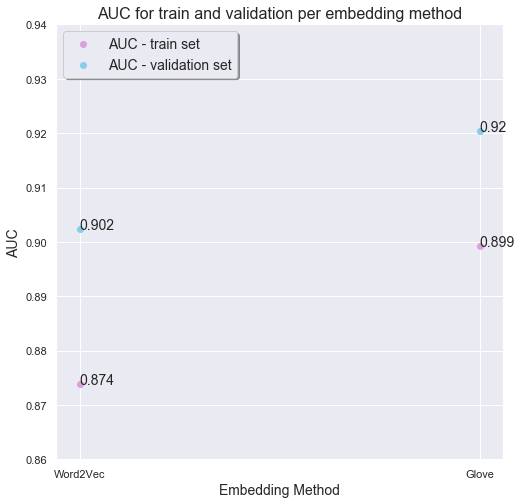

In [227]:
def calc_auc(w2v_pred_train, w2v_pred_test, glove_pred_train, glove_pred_test):
    auc_train_w2v = roc_auc_score(labels_train, w2v_pred_train)  # calculate auc
    auc_train_glove = roc_auc_score(labels_train, glove_pred_train) 
    auc_test_w2v = roc_auc_score(labels_valid, w2v_pred_test) 
    auc_test_glove = roc_auc_score(labels_valid, glove_pred_test) 
    embedding_lst = ['Word2Vec', 'Glove']
    auc_lst_train = [auc_train_w2v, auc_train_glove]
    auc_lst_valid = [auc_test_w2v, auc_test_glove]
    plt.figure(figsize = (8, 8))  # create visualizaion                                                          
    plt.scatter(embedding_lst, auc_lst_train, label = 'AUC - train set', color = 'plum')  
    plt.scatter(embedding_lst, auc_lst_valid, label = 'AUC - validation set', color = 'skyblue') 
    plt.annotate(str(round(auc_train_w2v,3)),xy=('Word2Vec',auc_train_w2v), fontsize = 14)
    plt.annotate(str(round(auc_test_w2v,3)),xy=('Word2Vec',auc_test_w2v), fontsize = 14)
    plt.annotate(str(round(auc_train_glove,3)),xy=('Glove',auc_train_glove), fontsize = 14)
    plt.annotate(str(round(auc_test_glove,3)),xy=('Glove',auc_test_glove), fontsize = 14)
    plt.title('AUC for train and validation per embedding method', fontsize = 16) 
    plt.xlabel('Embedding Method', fontsize = 14)                                                    
    plt.ylabel('AUC', fontsize = 14)
    plt.ylim(0.86, 0.94)
    plt.legend(fancybox = True, shadow = True, loc = 'upper left', fontsize = 14)
    plt.show()

calc_auc(w2v_pred_train, w2v_pred_test, glove_pred_train, glove_pred_test)

In this graph we can see clearly the AUC in both sets and both embeddings method. As seen, in both validation and train sets the classifier using Glove method performance is better. For that we can assume given the NN parameters that were set above, the model that used the embedding method of Glove performed better. In addition, we can see that the w2v performance are good as well (AUC above 0.87). It is also worth mentioning that if we would have used different combinations of embedding vector sizes in the different methods we might would have reach better AUC results. 

In [224]:
def create_label(prob_vec, treshold):  # this function creates a label for each review by it's given probabilty
    final_labels = []
    for r in prob_vec:
        if r < treshold:
            l = 0
        else:
            l = 1
        final_labels.append(l)
    return final_labels
        
t_hold = 0.5
labels_w2v_test = create_label(w2v_pred_test, 0.5)
labels_glove_test = create_label(glove_pred_test, 0.5)

In [225]:
def indexes(model_pred, emb_name):
    cm = confusion_matrix(labels_valid, model_pred)  # creating a confusion matrix object
    tn, fp, fn, tp = cm.ravel()  # taking the different parameters
    final_cm = np.array([[tp, fp], [fn, tn]])  # create the matrix

    # plot the confusion matrix by an heat map
    sns.heatmap(final_cm, cmap = "Greens", annot = True, fmt = "d",cbar = False, linewidth = 0.3, xticklabels = ['1','0'], yticklabels = ['1','0'])
    plt.xlabel('True label')                                                          
    plt.ylabel('Prediction')                                                         
    plt.title('Confusion matrix of ' + emb_name) 
    b, t = plt.ylim()  # take the bottom and top values 
    b += 0.5  # add 0.5 to the bottom
    t -= 0.5  # subtract 0.5 from the top
    plt.ylim(b, t)  # update the ylim(bottom, top) valu
    plt.show()
          
    print('True Positive(TP) = ' + str(tp) + ', correct classification - the model predicts that the label is 1 and the true label is 1')
    print('False Positive(FP) = ' + str(fp) + ', incorrect classification - the model predicts that the label is 1 but the label is 0')
    print('True Negative(TN) = ' + str(tn) + ', correct classification - the model predicts that the label is 0 and the true label is 0')
    print('False Negative(FN) = ' + str(fn) + ', incorrect classification - the model predicts that the label is 0 but the true label is 1')
    
    # presenting the different indexes
    acc = accuracy_score(labels_valid, model_pred)
    rec = recall_score(labels_valid, model_pred)
    prec = precision_score(labels_valid, model_pred)
    spec = str(tn / (tn + fp))
    fpr = str(fp / (tn + fp))
    return [acc, rec, prec, spec, fpr]

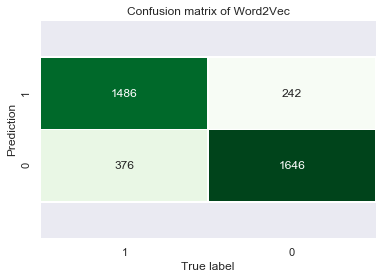

True Positive(TP) = 1486, correct classification - the model predicts that the label is 1 and the true label is 1
False Positive(FP) = 242, incorrect classification - the model predicts that the label is 1 but the label is 0
True Negative(TN) = 1646, correct classification - the model predicts that the label is 0 and the true label is 0
False Negative(FN) = 376, incorrect classification - the model predicts that the label is 0 but the true label is 1


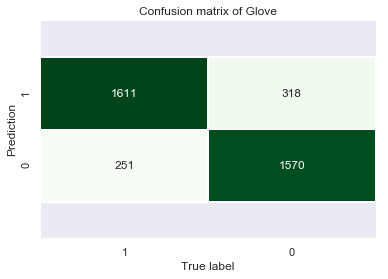

True Positive(TP) = 1611, correct classification - the model predicts that the label is 1 and the true label is 1
False Positive(FP) = 318, incorrect classification - the model predicts that the label is 1 but the label is 0
True Negative(TN) = 1570, correct classification - the model predicts that the label is 0 and the true label is 0
False Negative(FN) = 251, incorrect classification - the model predicts that the label is 0 but the true label is 1


,Accuracy,Recall,Precision,Specificity,FPR
Word2Vec,0.835200,0.798067,0.859954,0.871822033898305,0.1281779661016949
Glove,0.848267,0.865199,0.835148,0.8315677966101694,0.1684322033898305


In [226]:
index_w2v = indexes(labels_w2v_test, 'Word2Vec')
index_glove = indexes(labels_glove_test, 'Glove')
metrics = ['Accuracy', 'Recall', 'Precision', 'Specificity', 'FPR']
scores_table = pd.DataFrame([index_w2v, index_glove], columns = metrics, index = ['Word2Vec', 'Glove'])
scores_table.head()

From examining the metrics results table, we can see that the Accuracy score is quite similiar for both classifiers, and is around 0.84. A second look at the confusion matrices above will show that Word2Vec will tend to label more reviews as 0 than 1 (more negative than positive), while glove will tend to do the opposite and label more reviews as 1 than 0. We can also see that most of the reviews are correctly identified with their true label in both embedding methods. 
The recall metric (aka Sensitivity) is better using the Glove embeddig method which makes sense because as said above, this model tends label more 1s than 0s. For the same reason, the Specificity metric is better when using Word2Vec embedding method since it tends to label more 0s than 1s, but in this case the gap is smaller between the models.

### Conclusions
In our project we chose to examin our NLP classification model while comparing two different embedding methods - Word2Vec and Glove. Word2Vec takes texts as training data for a neural network, The resulting embedding captures whether words appear in similar contexts. GloVe focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together. The performance of the Glove method was better in our case, presenting AUC on the validation set which is higher in about 0.02. These results go hand in hand with our primal assamption that the two embedding methods will lead to pretty similiar results, since the gap shown here is quite small. 
To sum up, the pipeline given above can be used to perform further research on different NLP problems using these or other embedding methods.